In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [2]:
def load_and_normalize_data(filepath, last_n_days=30):
    df = pd.read_csv(filepath)
    close_prices = df[['Close']].values
    # print(len(close_prices))
    # print(close_prices.shape)
    # Normalize the data
    # Exclude the last 30 days for the training set
    training_data = close_prices[:-last_n_days]
    testing_data = close_prices[-last_n_days:]
    return torch.FloatTensor(training_data), torch.FloatTensor(testing_data), torch.FloatTensor(close_prices)

In [3]:
t, v, df = load_and_normalize_data('BTC-USD.csv', last_n_days=30)
print(len(t))
print(t.shape)
print(len(v))
print(len(df))

336
torch.Size([336, 1])
30
366


In [4]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw - 1):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw:i + tw + 1]
        inout_seq.append((train_seq, train_label))
        # print(inout_seq.shape)
    return inout_seq

In [36]:
def prepare_datasets(data, features, last_n_days, batch_size, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1,
                     use_scaler=True):
    # Ensure the split ratios sum to 1
    # assert (train_ratio + val_ratio + test_ratio) == 1, "Ratios must sum to 1"

    # Select the specified features from the dataset
    selected_data = data[features].values  # Assuming 'data' is a DataFrame

    # Normalize the dataset if use_scaler is True
    if use_scaler:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(selected_data)
    else:
        scaled_data = selected_data

    # Create sequences
    X, y = [], []
    for i in range(last_n_days, len(scaled_data)):
        X.append(scaled_data[i - last_n_days:i])
        y.append(scaled_data[i, :])  # Assumes you want to predict all features at the next time step
    X, y = np.array(X), np.array(y)

    # Convert to PyTorch tensors
    X_tensor, y_tensor = torch.FloatTensor(X), torch.FloatTensor(y)

    # Calculate split sizes
    total_samples = X_tensor.size(0)
    train_size = int(total_samples * train_ratio)
    val_size = int(total_samples * val_ratio)
    test_size = total_samples - train_size - val_size

    # Split the data
    train_X, train_y = X_tensor[:train_size], y_tensor[:train_size]
    val_X, val_y = X_tensor[train_size:train_size + val_size], y_tensor[train_size:train_size + val_size]
    test_X, test_y = X_tensor[-test_size:], y_tensor[-test_size:]

    # Wrap the datasets with TensorDataset
    train_dataset = TensorDataset(train_X, train_y)
    val_dataset = TensorDataset(val_X, val_y)
    test_dataset = TensorDataset(test_X, test_y)

    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Example usage
# Assuming 'btc_data' is your DataFrame containing the BTC dataset
# features_to_use = ['Close', 'Open', 'Low']  # Specify the features you want to use
# batch_size = 64  # Define your batch size
# train_loader, val_loader, test_loader = prepare_datasets(btc_data, features_to_use, last_n_days=60, batch_size=batch_size, use_scaler=True)


In [37]:
class LSTM_GRU_Model(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=64, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        # LSTM Layer
        self.init_lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_layer_size, hidden_layer_size, batch_first=True)

        # GRU Layer - input size matches LSTM output size (hidden_layer_size)
        self.gru = nn.GRU(hidden_layer_size, hidden_layer_size, batch_first=True)
        self.s_gru = nn.GRU(hidden_layer_size // 2, hidden_layer_size // 4, batch_first=True)
        self.s2_gru = nn.GRU(hidden_layer_size // 4, hidden_layer_size, batch_first=True)
        self.gru_after_bi = nn.GRU(hidden_layer_size * 2, hidden_layer_size, batch_first=True)

        # Linear layer to get to the output size
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # LSTM layer
        lstm_out, _ = self.init_lstm(input_seq)
        # lstm_out, _ = self.lstm(lstm_out)
        # lstm_out, _ = self.lstm(lstm_out)
        # lstm_out, _ = self.lstm(lstm_out)

        # GRU layer
        gru_out, _ = self.gru(lstm_out)
        # lstm_out, _ = self.lstm(gru_out)
        # gru_out, _ = self.s_gru(gru_out)
        # gru_out, _ = self.s2_gru(gru_out)
        # gru_out, _ = self.gru(gru_out)
        # gru_out, _ = self.gru(gru_out)

        # We use the output of the GRU layer for our predictions
        predictions = self.linear(gru_out[:, -1, :])
        return predictions

In [38]:
def train_val_model(model, train_loader, val_loader, loss_function, optimizer, epochs=10):
    for i in range(epochs):
        # train loop
        train_loss_list = []
        train_running_loss = 0.0
        s0 = datetime.now()
        for seq, labels in train_loader:
            optimizer.zero_grad()
            # print(seq)
            # print(labels)
            # exit()

            y_pred = model(seq)
            labels = labels.view(-1, 1)

            single_loss = loss_function(y_pred, labels)
            train_running_loss += single_loss.item() * seq.size(0)

            single_loss.backward()
            optimizer.step()

        # Calculate train loss
        train_loss = train_running_loss / len(train_loader)
        train_loss_list.append(train_loss)

        # test loop
        val_loss_list = []
        val_running_loss = 0.0
        model.eval()
        test_predictions = []
        actual_prices = []
        with torch.no_grad():
            for seq, labels in val_loader:
                predict_price = model(seq)
                labels = labels.view(-1, 1)

                test_predictions.append(predict_price)
                actual_prices.append(labels)

                single_loss = loss_function(predict_price, labels)
                val_running_loss += single_loss.item()
        # print(val_running_loss)
        # print(len(test_loader))
        val_loss = val_running_loss / len(val_loader)
        val_loss_list.append(val_loss)

        timing = datetime.now() - s0
        print(f'Epoch {i} | train_loss: {train_loss} | val_loss: {val_loss} | time: {timing}')


In [39]:
def train_val_model(model, train_loader, val_loader, loss_function, optimizer, device, epochs=10):
    model.to(device)  
    
    # Initialize loss lists 
    train_loss_list = []
    val_loss_list = []
    
    for i in range(epochs):
        model.train()
        train_running_loss = 0.0
        s0 = datetime.now()
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.to(device)
            
            optimizer.zero_grad()
            y_pred = model(seq)
            labels = labels.view(-1, 1)  

            single_loss = loss_function(y_pred, labels)
            train_running_loss += single_loss.item() * seq.size(0)
            
            single_loss.backward()
            optimizer.step()

        # Calculate train loss for this epoch
        train_loss = train_running_loss / len(train_loader.dataset)
        train_loss_list.append(train_loss)
        
        # Validation loop
        val_running_loss = 0.0
        model.eval()
        with torch.no_grad():
            for seq, labels in val_loader:
                seq, labels = seq.to(device), labels.to(device)
                
                predict_price = model(seq)
                labels = labels.view(-1, 1)  

                single_loss = loss_function(predict_price, labels)
                val_running_loss += single_loss.item() * seq.size(0)
                
        # Calculate validation loss for this epoch
        val_loss = val_running_loss / len(val_loader.dataset)
        val_loss_list.append(val_loss)

        timing = datetime.now() - s0
        print(f'Epoch {i} | train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | time: {timing}')

    return train_loss_list, val_loss_list


In [40]:
def evaluate_model(model, test_loader, device, loss_function):
    model.eval()  
    test_running_loss = 0.0
    
    with torch.no_grad(): 
        for seq, labels in test_loader:
            seq, labels = seq.to(device), labels.to(device)
            labels = labels.view(-1, 1)  
            
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            test_running_loss += single_loss.item() * seq.size(0)
            
    test_loss = test_running_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    
    return test_loss

In [41]:

def plot_predictions(full_data, predict_data, last_n_days=30):
    # Plot the full dataset
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Actual Prices', color='grey', alpha=0.5)

    # Highlight the last N days in the dataset for actual prices
    plt.plot(df.index[-last_n_days:], df['Close'][-last_n_days:], label='Last N Days Actual Prices', color='blue')

    # Assuming predictions_scaled is a numpy array with the shape (last_n_days, 1)
    # And the last N days are the target of these predictions
    # Create a range for the last N days
    prediction_dates = df.index[-last_n_days:]
    plt.plot(prediction_dates, predictions_scaled, label='Predicted Prices', linestyle='--', color='red')

    plt.title('Bitcoin Price Prediction - Full Year with Last N Days Highlighted')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [62]:
features_to_use = ['close']  
df = pd.read_csv('XAUUSD-M15')
train, val, test = prepare_datasets(df, features_to_use, last_n_days=60, batch_size=128, use_scaler=True)

model = LSTM_GRU_Model(hidden_layer_size=128)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device is: ', device)
train_val_model(model, train, val, loss_function, optimizer, device, epochs=40)


device is:  cuda:0
Epoch 0 | train_loss: 0.0203 | val_loss: 0.0022 | time: 0:00:00.851448
Epoch 1 | train_loss: 0.0095 | val_loss: 0.0016 | time: 0:00:00.477403
Epoch 2 | train_loss: 0.0088 | val_loss: 0.0012 | time: 0:00:00.469439
Epoch 3 | train_loss: 0.0082 | val_loss: 0.0009 | time: 0:00:00.474415
Epoch 4 | train_loss: 0.0079 | val_loss: 0.0008 | time: 0:00:00.460469
Epoch 5 | train_loss: 0.0073 | val_loss: 0.0007 | time: 0:00:00.467436
Epoch 6 | train_loss: 0.0067 | val_loss: 0.0006 | time: 0:00:00.461473
Epoch 7 | train_loss: 0.0059 | val_loss: 0.0006 | time: 0:00:00.485376
Epoch 8 | train_loss: 0.0049 | val_loss: 0.0006 | time: 0:00:00.462462
Epoch 9 | train_loss: 0.0037 | val_loss: 0.0006 | time: 0:00:00.487370
Epoch 10 | train_loss: 0.0027 | val_loss: 0.0007 | time: 0:00:00.495342
Epoch 11 | train_loss: 0.0024 | val_loss: 0.0007 | time: 0:00:00.464465
Epoch 12 | train_loss: 0.0017 | val_loss: 0.0007 | time: 0:00:00.495343
Epoch 13 | train_loss: 0.0015 | val_loss: 0.0006 | time

([0.020342738236350605,
  0.009535011375864723,
  0.008807359324672151,
  0.008241548486659775,
  0.007876986978598033,
  0.007253231265601496,
  0.006699909893604633,
  0.005946564197004686,
  0.0048889818805310644,
  0.003674283264691222,
  0.0026944839472701964,
  0.0023997620682622276,
  0.0016517730505826462,
  0.0015168819847591818,
  0.0009521805940859278,
  0.000846024667009547,
  0.0006052128696015654,
  0.0004938790049986336,
  0.000377722273819534,
  0.0002768865478965983,
  0.00019046981247474262,
  0.00011868829137550124,
  8.426005016183168e-05,
  0.00011135477549855181,
  9.965808999569038e-05,
  9.18386581789544e-05,
  8.736262046001256e-05,
  8.338966784294342e-05,
  7.976696443058893e-05,
  7.719511019948731e-05,
  7.626021118166698e-05,
  7.659358822556268e-05,
  7.671941286018396e-05,
  7.521344114897773e-05,
  7.235386984811569e-05,
  6.903746470688849e-05,
  6.534626106404058e-05,
  6.149970731329581e-05,
  5.8911619148467134e-05,
  5.8273432940766214e-05],
 [0.00

In [63]:
evaluate_model(model, test, device, loss_function)

Test Loss: 0.0000


1.9017089689540446e-06

In [64]:
import matplotlib.pyplot as plt

def plot_predictions(actual, predicted, title='Actual vs Predicted'):
    plt.figure(figsize=(10,6))
    plt.scatter([a for a in range(len(actual))], actual, label='Actual Values', color='blue')
    plt.scatter([a for a in range(len(predicted))], predicted, label='Predicted Values', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


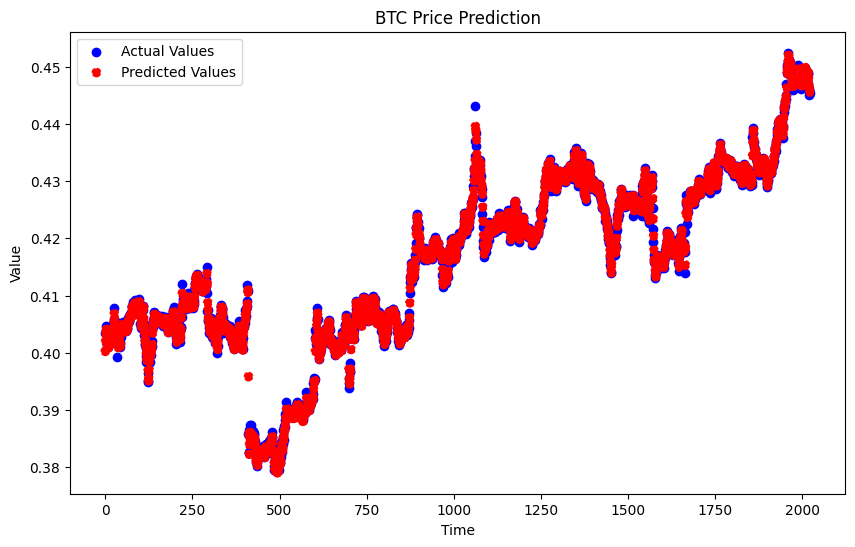

In [65]:
actual_prices = []
predicted_prices = []

model.eval()
for dataloader in [test]:
    with torch.no_grad():
        for seq, labels in dataloader:
            seq, labels = seq.to(device), labels.to(device)
            
            # Predict
            predictions = model(seq)
            
            # Collect actual and predicted values
            actual_prices.extend(labels.cpu().view(-1).numpy())
            predicted_prices.extend(predictions.cpu().view(-1).numpy())

# Assuming your test_loader doesn't shuffle the data, so the sequences are in order
plot_predictions(actual_prices, predicted_prices, title='BTC Price Prediction')


In [ ]:
filepath = 'EURUSD=X(1).csv'
seq_length = 90
train_data, val_data, df = load_and_normalize_data(filepath, last_n_days=200)
train_sequences = create_inout_sequences(train_data, seq_length)
# print(train_sequences[0])
val_sequences = create_inout_sequences(val_data, seq_length)
train_loader = DataLoader(train_sequences, batch_size=200)
for seq, labels in train_loader:
    print('seq: ', seq.shape)
    print('labels: ', labels.shape)
    exit()
val_loader = DataLoader(val_sequences, batch_size=64)
model = LSTM_GRU_Model(hidden_layer_size=64)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_val_model(model, train_loader, val_loader, loss_function, optimizer, epochs=10)


In [ ]:
len(val_loader)